# DelayedFunction

Данная библиотека создана как попытка решить следующую задачу. Есть некий продакшен-пайплайн вычислений, который нам необходимо создать, и кластерная система. Пайплайн, возможно, содержит циклические зависимости и условные переходы. В рамках одной программы подобные пайплайны создавать просто: надо просто писать код. Все меняется, когда мы запускаемся на какой-нибудь кластерной системе: необходимо создавать дополнительное окружение, заботиться о пересылке данных между кусками пайплайнов, следить за правильным выполнением пайплайна и обработкой ошибок и пр. 

Данная библиотека создана с целью взять на себя все задачи по внедрению кода в облачные системы. Философия такая: мы создаем некую программу, которая делает наш пайплайн вычислений, в виде обычной программы на Python. Мы пишем программу и оборачиваем все вычисления в функции или функторы (как правило, это условие выполнено всегда). Можно запускать этот код локально - и он проделает все вычисления. Дальше мы оборачиваем все функции в некоторый декоратор, и у нас появляется возможность одним нажатием кнопки запустить пайплайн на кластерной системе и иметь гарантии того, что код в облаке выполнится в точности так же, как на локальной машине. 

Один пример - лучше 1000 слов.

In [3]:
import sys
sys.path.append('../')
from delayed.delayed_function import delayed_function, build_dependency_graph
from runner.local_runner import run_local

In [5]:
@delayed_function(outputs=(object, object), inputs=dict(x=object, y=object))
def add(x, y):
    return x + 1, y + 1

@delayed_function(outputs=(object, object), inputs=dict(x=object, y=object))
def mul(x, y):
    return x * 10, y * 10

@delayed_function(outputs=(object, object), inputs=dict(x=object, y=object))
def div(x, y):
    return x / 2, y / 2

@delayed_function(outputs=(), inputs=dict(x=object, y=object, z=object, w=object))
def print_nums(x, y, z, w):
    print(x, y, z, w)

In [ ]:
class DelayedList(list):
    pass

In [ ]:
@delayed_function(outputs=(object, object), inputs=(DelayedList(object)))

In [6]:
s = "123"

In [ ]:
s.is

## API: декоратор delayed_function

У данного декоратора 3 параметра:
* outputs: tuple из типов возвращаемых значений. Длина tuple, разумеется, должна быть такой же, как длина кортежа для return функции
* inputs: dict(arg_name=arg_type). Должен покрывать все аргументы в декорируемой функции.
* container_params - словарь с параметрами того, как мы будем оборачивать функцию в некий контейнер для удаленного запуска. В данном простом примере необходимо просто указать его тип

Можно сразу отметить: outputs и inputs **статически типизированы**, что крайне нетипично для Python. Это необходимая жертва для того, чтобы модуль сериализации данных мог автоматически обрабатывать передаваемые значения: для работы ему необходимо знать лишь тип переменной, остальное он сделает сам.

**Это не превращает Python в код на C++**: дальше будет показано, что можно везде указать object, тогда будет использоваться просто дефолтный сериализатор, умеющий обрабатывать любые Python объекты

### Дефолтное поведение

По умолчанию, декоратор delayed_function **ничего не делает**:

In [3]:
a, b = add(1, 2)
c, d = mul(3, 4)
e, f = div(b, c)

a, b = mul(a, e)
c, d = add(f, d)
print_nums(a, b, c, d)

20 15.0 16.0 41


### Граф отложенных вычислений: не-дефолтное поведение

Это то, зачем нужна вся библиотека. Если внести код под контекстный менеджер 

In [4]:
with build_dependency_graph("math_program"):
    a, b = add(1, 2)
    c, d = mul(3, 4)
    e, f = div(b, c)

    a, b = mul(a, e)
    c, d = add(f, d)
    print_nums(a, b, c, d)

То исполнение кода вообще не приведет к вызову декорированных функций. Вместо этого, создастся **граф отложенных вычислений**

In [18]:
from utils.draw_digraph import draw_graph
from graph.dependency_graph import H

%matplotlib inline

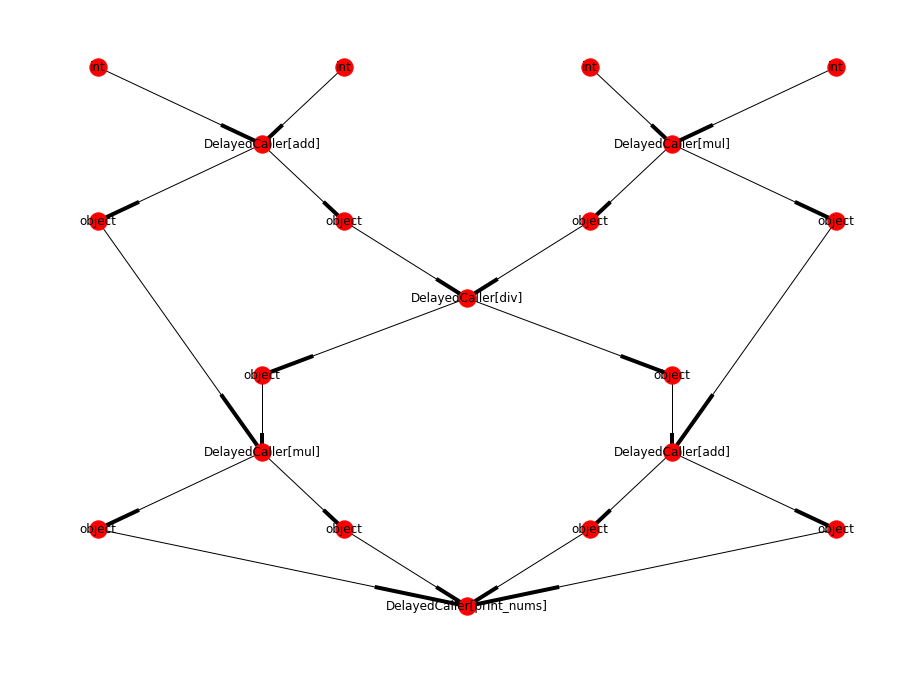

In [21]:
with build_dependency_graph("math_program"):
    draw_graph(H.dependency_graph, figsize=(16, 12))

Все, конкретно в данном примере от пользователя больше ничего не требуется. Дальше лишь требуется выбрать тип runner. Конкретно сейчас доступен только **run_local**, в ближайшем будущем будет запуск на Nirvana

In [23]:
delayed_values = run_local("math_program")

20 15.0 16.0 41


run_local правильно вычислил все переменные, однако помимо этого он вернул словарь со всеми промежуточными delayed значениями

In [25]:
delayed_values

{int: 1,
 int: 2,
 int: 3,
 int: 4,
 object: 30,
 object: 40,
 object: 2,
 object: 3,
 object: 1.5,
 object: 15.0,
 object: 20,
 object: 15.0,
 object: 16.0,
 object: 41}